In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
train_x = Variable(torch.linspace(0, 1, 1000))
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [104]:
class DeepNet(nn.Sequential):
    def __init__(self):
        super(DeepNet, self).__init__(
            nn.Linear(1, 100),
            nn.ReLU(True),
            nn.Linear(100, 1)
        )
        
deep_net = DeepNet()
# Optimize the model
deep_net.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(deep_net.parameters(), lr=0.1, weight_decay=1e-3)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = deep_net(train_x.unsqueeze(1))
    loss = criterion(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()
deep_net.eval()

old_params = model.deep_net.parameters().next()[0:20]

Iter 1/30 - Loss: 0.561
Iter 2/30 - Loss: 6.824
Iter 3/30 - Loss: 0.510
Iter 4/30 - Loss: 3.271
Iter 5/30 - Loss: 2.856
Iter 6/30 - Loss: 1.207
Iter 7/30 - Loss: 0.479
Iter 8/30 - Loss: 0.795
Iter 9/30 - Loss: 1.015
Iter 10/30 - Loss: 0.873
Iter 11/30 - Loss: 0.626
Iter 12/30 - Loss: 0.543
Iter 13/30 - Loss: 0.670
Iter 14/30 - Loss: 0.580
Iter 15/30 - Loss: 0.532
Iter 16/30 - Loss: 0.592
Iter 17/30 - Loss: 0.543
Iter 18/30 - Loss: 0.500
Iter 19/30 - Loss: 0.517
Iter 20/30 - Loss: 0.530
Iter 21/30 - Loss: 0.504
Iter 22/30 - Loss: 0.476
Iter 23/30 - Loss: 0.480
Iter 24/30 - Loss: 0.489
Iter 25/30 - Loss: 0.479
Iter 26/30 - Loss: 0.472
Iter 27/30 - Loss: 0.478
Iter 28/30 - Loss: 0.471
Iter 29/30 - Loss: 0.465
Iter 30/30 - Loss: 0.471
Iter 31/30 - Loss: 0.469
Iter 32/30 - Loss: 0.463
Iter 33/30 - Loss: 0.465
Iter 34/30 - Loss: 0.466
Iter 35/30 - Loss: 0.459
Iter 36/30 - Loss: 0.458
Iter 37/30 - Loss: 0.459
Iter 38/30 - Loss: 0.455
Iter 39/30 - Loss: 0.452
Iter 40/30 - Loss: 0.452
Iter 41/3

In [105]:
class DklGPModel(gpytorch.GPModel):
    def __init__(self, deep_net):
        super(DklGPModel, self).__init__(GaussianLikelihood(log_noise_bounds=(-5, 5)))
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        self.deep_net = deep_net

        covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
        self.grid_covar_module = GridInterpolationKernel(covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-1, 1))
        self.initialize_interpolation_grid(50, grid_bounds=[(-5, 5)])
        covar_module.initialize(log_lengthscale=5)

    def forward(self, x):
        mean_x = self.mean_module(x)
        features = self.deep_net(x.unsqueeze(1))
        covar_x = self.grid_covar_module(features)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)
    
model = DklGPModel(deep_net)
model.condition(train_x, train_y)

DklGPModel (
  (likelihood): GaussianLikelihood (
  )
  (mean_module): ConstantMean (
  )
  (deep_net): DeepNet (
    (0): Linear (1 -> 100)
    (1): ReLU (inplace)
    (2): Linear (100 -> 1)
  )
  (grid_covar_module): GridInterpolationKernel (
    (base_kernel_module): RBFKernel (
    )
  )
)

In [71]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

In [106]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(30):
    optimizer.zero_grad()
    output = model(train_x)
    print(torch.equal(output.covar().c.data, output.covar().c.data))
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/30 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

True
Iter 1/30 - Loss: 1022.079
True
Iter 2/30 - Loss: 970.588
True
Iter 3/30 - Loss: 922.484
True
Iter 4/30 - Loss: 880.545
True
Iter 5/30 - Loss: 832.675
True
Iter 6/30 - Loss: 789.828
True
Iter 7/30 - Loss: 742.733
True
Iter 8/30 - Loss: 699.150
True
Iter 9/30 - Loss: 660.166
True
Iter 10/30 - Loss: 625.523
True
Iter 11/30 - Loss: 584.864
True
Iter 12/30 - Loss: 546.868
True
Iter 13/30 - Loss: 509.597
True
Iter 14/30 - Loss: 476.526
True
Iter 15/30 - Loss: 440.964
True
Iter 16/30 - Loss: 409.830
True
Iter 17/30 - Loss: 377.419
True
Iter 18/30 - Loss: 350.558
True
Iter 19/30 - Loss: 324.124
True
Iter 20/30 - Loss: 306.930
True
Iter 21/30 - Loss: 283.411
True
Iter 22/30 - Loss: 253.411
True
Iter 23/30 - Loss: 232.681
True
Iter 24/30 - Loss: 223.751
True
Iter 25/30 - Loss: 198.506
True
Iter 26/30 - Loss: 180.021
True
Iter 27/30 - Loss: 159.431
True
Iter 28/30 - Loss: 141.360
True
Iter 29/30 - Loss: 126.270
True
Iter 30/30 - Loss: 105.710


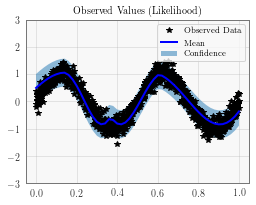

In [107]:
f = plot_model_and_predictions(model, plot_train_data=True)

In [108]:
model.deep_net.parameters().next()[0:20]

Variable containing:
-6.9271e-01
-1.4959e-01
-2.9167e-02
 3.4251e-04
-1.1805e+00
 1.0660e+00
-1.5155e-03
-6.2615e-02
-3.5773e-02
-1.4900e-03
-4.4849e-01
-7.1094e-01
-5.2040e-01
-4.4658e-01
-3.3985e-01
 1.4964e-01
-5.7198e-03
 3.5688e-01
-3.4298e+00
-8.2014e-05
[torch.FloatTensor of size 20x1]

In [109]:
old_params

Variable containing:
-2.1611e-01
-3.5956e-04
-4.4229e-01
-4.5490e-02
 1.5626e-05
-4.0939e-02
 3.3181e-01
-1.5156e-01
-4.1293e-01
-5.4457e-05
 1.1744e-01
-1.8349e-01
-1.7113e-01
 2.2095e+00
-4.5600e-05
 1.1580e-01
-1.8889e-05
-5.3148e-01
-1.6299e-01
 1.0680e+00
[torch.FloatTensor of size 20x1]